In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf #Adicionei como novo
plt.style.use('ggplot')

### Data Preprocessing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

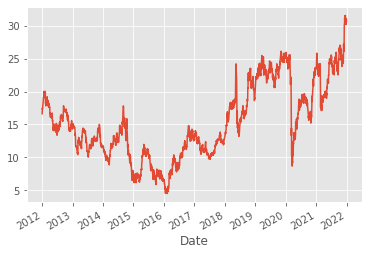

In [3]:
# Loading the dataset
df = yf.download(tickers='petr3.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [4]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.982913
High         0.984594
Low          0.983957
Close        0.985268
Adj Close    1.000000
Volume       0.002942
Name: Adj Close, dtype: float64

In [5]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    2.463000e+03
mean     1.395870e+07
std      1.288061e+07
min      1.610000e+04
25%      7.240400e+06
50%      1.084730e+07
75%      1.654765e+07
max      3.104194e+08
Name: Volume, dtype: float64


In [6]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [7]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [8]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [9]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [10]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [11]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

### Model Building

            Adj Close       Open        Low       High
Date                                                  
2012-01-02  16.632433  23.129999  22.740000  23.610001
2012-01-03  17.345390  23.209999  23.209999  24.020000
2012-01-04  17.453709  23.799999  23.570000  24.280001
2012-01-05  17.345390  24.100000  23.760000  24.309999
2012-01-06  17.330948  24.100000  23.910000  24.350000
...               ...        ...        ...        ...
2021-12-23  30.440001  30.350000  30.180000  30.680000
2021-12-27  31.040001  30.440001  30.240000  31.230000
2021-12-28  31.059999  31.260000  31.000000  31.469999
2021-12-29  30.950001  31.010000  30.750000  31.340000
2021-12-30  30.700001  30.950001  30.549999  31.129999

[2463 rows x 4 columns]


<AxesSubplot:xlabel='Date'>

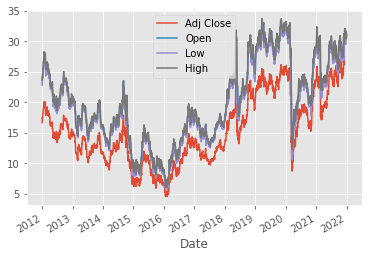

In [12]:
# Extracting the series
features = ['Adj Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series)
series.plot()

In [13]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1863, 4) (300, 4) (300, 4)


In [14]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1863, 4) (300, 4) (300, 4)


In [15]:
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 64
num_epochs = 100

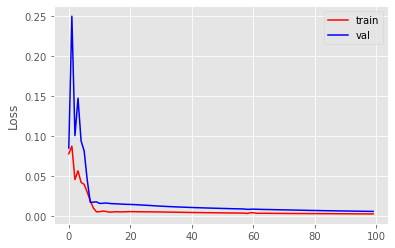

In [16]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.10677265717344568
MSE = 0.016191786862259912
RMSE = 0.1272469522710069
R-Squared Score = 0.27845958180318775


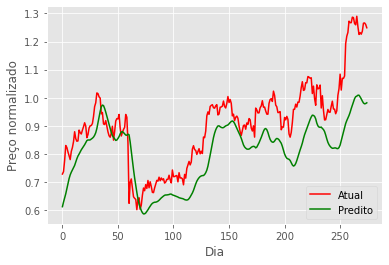

In [18]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [19]:
# Save a model
model.save('MV-LSTM PETR3')
del model # Deletes the model
# Load a model
model = load_model('MV-LSTM PETR3')

INFO:tensorflow:Assets written to: MV-LSTM PETR3\assets


## Cross-Validation

In [20]:
# Hyperparameters
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [21]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2463, 4)
            Adj Close       Open        Low       High
Date                                                  
2021-12-23  30.440001  30.350000  30.180000  30.680000
2021-12-27  31.040001  30.440001  30.240000  31.230000
2021-12-28  31.059999  31.260000  31.000000  31.469999
2021-12-29  30.950001  31.010000  30.750000  31.340000
2021-12-30  30.700001  30.950001  30.549999  31.129999


In [22]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.4478859 , 0.63592767, 0.62965697, 0.63587153],
       [0.47425549, 0.63887861, 0.64699372, 0.65066763],
       [0.47826177, 0.6606418 , 0.66027298, 0.66005053],
       ...,
       [0.9815069 , 0.93581705, 0.93434161, 0.91952359],
       [0.97743846, 0.92659536, 0.92511992, 0.91483217],
       [0.96819191, 0.92438218, 0.91774254, 0.90725364]])

### Split I

In [23]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.05507224347914395
MSE = 0.003450195756358987
RMSE = 0.058738366987506445
R-Squared Score = 0.6140136473826545


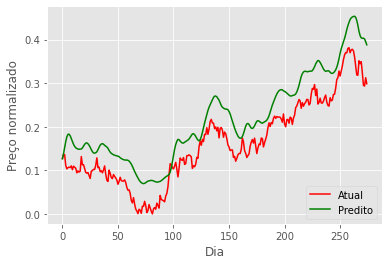

In [24]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split1.h5")

### Split II

Split 2
MAE = 0.06335500196503464
MSE = 0.004356188857842022
RMSE = 0.06600143072572004
R-Squared Score = -0.5472842090888423


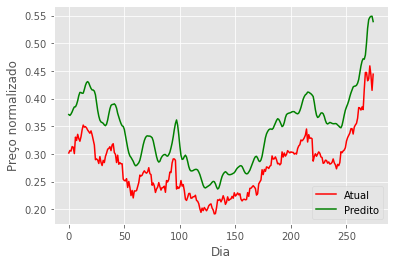

In [25]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split2.h5")

### Split III

Split 3
MAE = 0.11438948473650443
MSE = 0.014518708539882897
RMSE = 0.12049360373016858
R-Squared Score = -0.020800300744148403


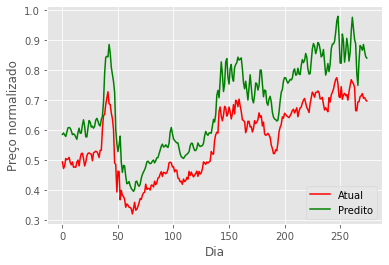

In [26]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split3.h5")

### Split IV

Split 4
MAE = 0.1277332400205735
MSE = 0.019272178506272858
RMSE = 0.13882427203581102
R-Squared Score = 0.30729472529336266


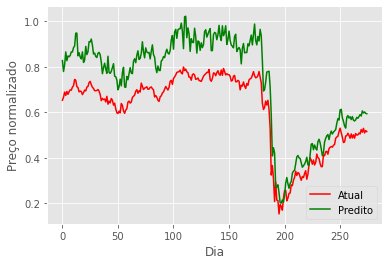

In [27]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split4.h5")

### Split V

Split 5
MAE = 0.06236964752334527
MSE = 0.004969697471104902
RMSE = 0.07049608124644165
R-Squared Score = 0.5857545900421466


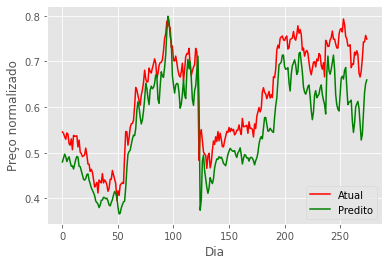

In [28]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-LSTM-Split5.h5")

In [29]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.08458392354492036
Avg. MSE = 0.009313393826292333
Avg. RMSE = 0.09091075094512954
Avg. R2-score = 0.1877956905770346


In [30]:
CV_results.to_csv('LSTM-M PETR3.csv')
#train_loss.to_csv('PETR_MV3-LSTM_CrossValidation_TrainLoss.csv')
#val_loss.to_csv('PETR_MV3-LSTM_CrossValidation_ValLoss.csv')